# Overview

The aim of this Kernel is to apply the knowledge acquired in the first part ot the subject "Big Data Intelligence: methods and technologies" taught in the "Master in Big Data analytics" of the university Carlos III of Madrid

The main concepts to be learned in this part of the subject are
    - How to make data partition to train/test the model (Holdout & Cross Validation)
    - How to tune the hyperparamethers for the model
    

# Index
- Importing libraries
- Importing data
- Spliting the data to train the model
- Initializing CV
- 3.1.1 Grid Search for hyperparameter tuning KNN
    - 3.1.2 Model evaluation
- 3.2.1 Random search for Decision Trees
    - 3.2.2 Model Evaluation
- 3.3.1 Skopt for Decision Trees
    - 3.3.2 Model Evaluation
- Comparition between models
    - Scores
    - Time performance
- Final model
- Exporting the data
- Kaggle Score

    

# Importing Libraries

In [481]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from sklearn.metrics import mean_squared_error
, metrics
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold, GridSearchCV
from scipy.stats import randint
from datetime import datetime as time
from skopt import BayesSearchCV
from scipy.stats import uniform, expon
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import time

# Importing data


In [482]:
data = pd.read_csv("kaggleCompetition.csv")
data = data.values

X = data[0:1460,:-1]
y = data[0:1460,-1]
X_comp = data[1460:,:-1]
y_comp = data[1460:,-1]

# Spliting the data to train the model

This must be 100% understood. **YOU CAN NEVER EVALUATE YOUR MODEL WITH YOUR TRAINING DATA!**

So that is the reason to split the available data. One third of the data will be used to tune the evaluate the model, while the rest will be used to tune the hyperparameters of the different models using Cross-Validation (cv from now)

**C**ross **V**alidation is a kind of generating different scenarios for tuning the hyperparameters of our model. In this case, we will tune the hyperparameters using cv=3 and later we will evaluate the model with cv=4. That means that we divide our training data into four equal parts, eg. A,B,C,D and we will make all the possible combinations of three of them eg. B,D,C to train the model with the different hyperparameters and the use the fourth to test each model 

In [483]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=0)

# Initializing CV

In [484]:
kf_3=KFold(n_splits=3,shuffle=True,random_state=0)
kf_4=KFold(n_splits=4,shuffle=True,random_state=0)
np.random.seed(seed=100)

# 3.1.1 Grid Search for hyperparameter tuning KNN

KNN is a basic algorithm that computes the mean distance from other neighbors, and assing a mean from the k-nearest neighbors. It just depend on 1 hyperparameter, number of neighbors

The purpose of this part of the assingment is to generate a 1D-grid and test all points of that grid, selecting the one that provides better scores.

Best score occurs when  {'n_neighbors': 5}


Text(0,0.5,'Mean score')

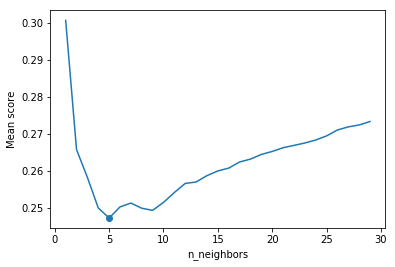

In [485]:
# Number of neigbors to try
param_grid = {'n_neighbors':list(range(1,30,1))}
method_knn=KNeighborsRegressor()

#Definition of the method: first tune n_neighbors with CV=3, then train KNN with best n_neighbors
clf = GridSearchCV(method_knn,
                    param_grid, 
                    cv=kf_3,
                    scoring='neg_mean_squared_error')

#Fiting the model with the train data and the best nº neighbors
start_3_1_1 = time.time()
clf.fit(X_train,y_train)
end_3_1_1=time.time()-start_3_1_1

clf_3_1=clf

scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores)
print("Best score occurs when ",clf.best_params_)
mark=[np.argmax(scores, axis=0)]
plt.plot(param_grid["n_neighbors"],np.sqrt(-scores),markevery=mark,marker="o")

plt.xlabel('n_neighbors')
plt.ylabel('Mean score')


## 3.1.2 Model evaluation

In [487]:
print("Mean CV scores for KNN with grid search: ",np.sqrt(-np.mean(cross_val_score(clf, X_test, y_test, cv=kf_4,scoring='neg_mean_squared_error'))))

Mean CV scores for KNN with grid search:  0.2459508292726629


# 3.2.1 Random search for Decision Trees

Decision tree is a very well known algorithm for machine learning. It consist on making branchings by minimizing the entrophy. The main hyperparameters to be tested are the max_depth (the number of heights of the tree) the min_samples_split (the minimum number of observations for each leave) and the decision criteria.

The purpose of this part of the assingment is to select randomly points from a 3D-grid and test it, selecting the one that provided better scores.


In [488]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": randint(2, 16),
              "min_samples_split": randint(2, 16),
              "criterion": ['mse','friedman_mse']}

# run randomized search
n_iter_search = 20
clf = RandomizedSearchCV(tree.DecisionTreeRegressor(),
                         param_distributions=param_dist,
                         scoring='neg_mean_squared_error',
                         n_iter=n_iter_search, cv=kf_3)
start_3_2_1 = time.time()
clf.fit(X_train,y_train)
end_3_2_1=time.time()-start_3_2_1
clf_3_2=clf

Text(0,0.5,'Mean score')

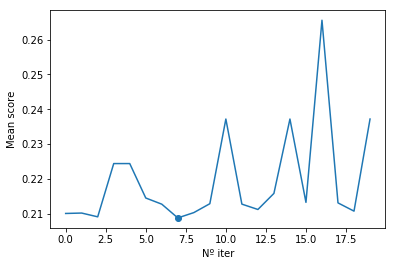

In [489]:
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores)
mark=[np.argmax(scores, axis=0)]
plt.plot(np.array(list(range(n_iter_search))),np.sqrt(-scores),markevery=mark,marker="o")

plt.xlabel('Nº iter')
plt.ylabel('Mean score')

## 3.2.2 Model Evaluation

In [491]:
np.random.seed(0)
print("Best parameters for Decision Trees Random Search: ",clf.best_params_)
print("Mean CV scores for Decision Trees Random search: ",np.sqrt(-np.mean(cross_val_score(clf, X_test, y_test, cv=kf_4,scoring='neg_mean_squared_error'))))

Best parameters for Decision Trees Random Search:  {'criterion': 'mse', 'max_depth': 13, 'min_samples_split': 11}
Mean CV scores for Decision Trees Random search:  0.21560907612447386


# 3.3.1 Skopt for Decision Trees

Finally, Bayesian optimization tries to look for the best hyperparameters but in a clever way, not just evaluating all the grid or randomly selecting points. It will provide more importance to those hyperparameters that has a higher impact on the model scores, so it will expend more time in this hyperparameters refinement.

In [492]:
# Search space with integer uniform distributions
param_grid = {'max_depth': (2,16),
              'min_samples_split': (2,16),
              'criterion':['mse','friedman_mse']}

budget = 20
# random.seed = 0 for reproducibility
np.random.seed(0)
clf = BayesSearchCV(tree.DecisionTreeRegressor(),
                    param_grid,
                    scoring='neg_mean_squared_error',
                    cv=kf_3,    
                    n_jobs=-1, verbose=0,
                    n_iter=budget
                   )
start_3_3_1 = time.time()
clf.fit(X_train,y_train)
end_3_3_1=time.time()-start_3_3_1

clf_3_3=clf

Text(0,0.5,'Mean score')

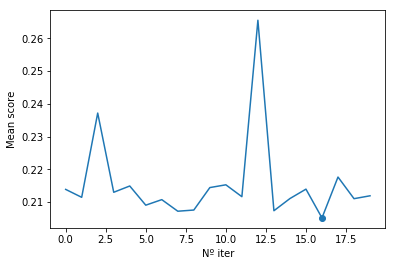

In [493]:
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores)
mark=[np.argmax(scores, axis=0)]
n_iter_search=10
plt.plot(np.array(list(range(budget))),np.sqrt(-scores),markevery=mark,marker="o")

plt.xlabel('Nº iter')
plt.ylabel('Mean score')

## 3.3.2 Model Evaluation 

In [497]:
np.random.seed(0)
print("Best parameters for Decision Trees Skopt: ",clf.best_params_)
print("Mean CV scores for Decision Trees Skopt: ",np.sqrt(-np.mean(cross_val_score(clf, X_test, y_test, cv=kf_4,scoring='neg_mean_squared_error',n_jobs=-1))))


Best parameters for Decision Trees Skopt:  {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_split': 2}
Mean CV scores for Decision Trees Skopt:  0.21433855844562888


# Comparition between models

## Scores

Best scores are achieved using Bayesian optimization for decision trees as we can see in the graph below

In [508]:
np.random.seed(seed=10)
df = pd.DataFrame(
    {"KNN" : np.sqrt(np.array(-cross_val_score(clf_3_1, X_test, y_test, cv=kf_4,scoring='neg_mean_squared_error',n_jobs=-1))),
    "Random Decision Trees" : np.sqrt(np.array(-cross_val_score(clf_3_2, X_test, y_test, cv=kf_4,scoring='neg_mean_squared_error',n_jobs=-1))),
    "Opt Decision Trees" : np.sqrt(np.array(-cross_val_score(clf_3_3, X_test, y_test, cv=kf_4,scoring='neg_mean_squared_error',n_jobs=-1)))
    }
)

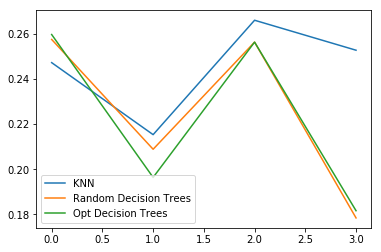

In [509]:
df.plot(legend=True)

In [510]:
df.mean(axis=0)

KNN                      0.245248
Random Decision Trees    0.225238
Opt Decision Trees       0.223464
dtype: float64

## Time performance

From the results above, we can see that there is a big difference between the model created using Bayesian optimization and the others. This could happend due to the complexity of the function that works inside this algorithm

In [511]:
print("Time required for fitting KNN:",end_3_1_1)
print("Time required for fitting Decision Trees with grid search:",end_3_2_1)
print("Time required for fitting Decision Trees with Bayesian opt:",end_3_3_1)


Time required for fitting KNN: 2.664536476135254
Time required for fitting Decision Trees with grid search: 0.40820741653442383
Time required for fitting Decision Trees with Bayesian opt: 30.327412366867065


# Final model

The best performance was achieved with the Bayesian optimization method. There is no time limits in this case, so this model will be the final one despite the fact that it is the one that takes higher time.

The hyperparameters selected are:
    - 'criterion': 'mse'
    - 'max_depth': 16
    - 'min_samples_split': 16
        

## Exporting the data

In [512]:
clf_3_3.fit(X,y)
y_comp=clf_3_3.predict(X_comp)
y_comp=np.array(y_comp)
y_comp_exp=np.exp(y_comp)

dat=pd.DataFrame(y_comp_exp)
dat.index = pd.RangeIndex(start=1461, stop=1461+dat.size,step=1)

dat.columns = ['SalePrice']
dat.to_csv("Final_Model.csv")

# Kaggle score

Finally, the score obtained in Kaggle was 0.19377, better than previous results, as expected because we are fiting the model with the whole dataset, not just with the training partition
